In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import*
from fastai.vision import*

In [3]:
path = Path('data/anime-faces')

In [4]:
data = ImageDataBunch.from_folder(path, bs = 64, size = 128, valid_pct = 0.2, ds_tfms = get_transforms()).normalize(imagenet_stats)

In [5]:
print(data.classes)

['000_hatsune_miku', '001_kinomoto_sakura', '002_suzumiya_haruhi', '003_fate_testarossa', '004_takamachi_nanoha', '005_lelouch_lamperouge', '006_akiyama_mio', '007_nagato_yuki', '008_shana', '009_hakurei_reimu', '010_izumi_konata', '011_kirisame_marisa', '012_asahina_mikuru', '013_saber', '014_hiiragi_kagami', '015_c.c', '016_furukawa_nagisa', '017_louise', '018_kagamine_rin', '019_ayanami_rei', '020_remilia_scarlet', '021_hirasawa_yui', '022_kururugi_suzaku', '023_hiiragi_tsukasa', '024_fujibayashi_kyou', '025_souryuu_asuka_langley', '026_tohsaka_rin', '027_izayoi_sakuya', '028_tainaka_ritsu', '029_kallen_stadtfeld', '030_aisaka_taiga', '031_kotobuki_tsumugi', '032_yakumo_yukari', '033_kagamine_len', '034_sakagami_tomoyo', '035_yoko', '036_reisen_udongein_inaba', '037_lala_satalin_deviluke', '038_takara_miyuki', '039_yagami_hayate', '040_flandre_scarlet', '041_saigyouji_yuyuko', '042_tsukimura_mayu', '043_konpaku_youmu', '044_nakano_azusa', '045_patchouli_knowledge', '046_alice_margat

In [6]:
learn = cnn_learner(data, models.resnet50, metrics = accuracy)

In [7]:
learn.load('stage-3')

Learner(data=ImageDataBunch;

Train: LabelList (11518 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
000_hatsune_miku,000_hatsune_miku,000_hatsune_miku,000_hatsune_miku,000_hatsune_miku
Path: data\anime-faces;

Valid: LabelList (2879 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
139_caro_ru_lushe,044_nakano_azusa,008_shana,050_megurine_luka,179_siesta
Path: data\anime-faces;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), 

In [8]:
# this is a hook (learned about it 
# here: https://forums.fast.ai/t/how-to-find-similar-images-based-on-final-embedding-layer/16903/13)
#hooks are used for saving intermediate computations
class SaveFeatures():
    features=None
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output):
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features,out))
    def remove(self):
        self.hook.remove()

In [9]:
sf = SaveFeatures(learn.model[1][5]) # actual predictions
sf2 = SaveFeatures(learn.model[-1][-3]) # final batch norm

In [10]:
_=learn.get_preds(data.train_ds)
_=learn.get_preds(DatasetType.Valid)

In [11]:
X_train = sf.features
X_train2 = sf2.features
y_train = [y for y in (list(data.train_ds.y.items)+list(data.valid_ds.y.items))]

In [12]:
len(X_train),len(X_train2), len(y_train)

(14397, 14397, 14397)

In [13]:
#TIME FOR SOME PCA
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

In [69]:
n_components = X_train.shape[1]
pca = PCA(n_components)
# fit on training data, to avoid overfitting if the PCA features are used for a classifier
PCA_X_train = pca.fit_transform(X_train)
PCA_X_train2 = pca.transform(X_train2)

In [70]:
sorts = {}
sorts2 = {}
for i in range(n_components):
    sorts[i] = np.argsort(PCA_X_train[:,i])[::-1]
    sorts2[i] = np.argsort(PCA_X_train2[:,i])[::-1]

In [75]:
pickle.dump(sorts,open(path/'pca_sorts1.p', "wb"))
pickle.dump(sorts2,open(path/'pca_sorts2.p', "wb"))

In [76]:
sorts = pickle.load(open(path/'pca_sorts1.p', 'rb'))
sorts2 = pickle.load(open(path/'pca_sorts2.p', 'rb'))

In [55]:
images = [str(x) for x in (list(data.train_ds.items)+ list(data.valid_ds.items))]

In [56]:
images[0]

'data\\anime-faces\\train\\000_hatsune_miku\\face_128_326_108.png'

In [57]:
from PIL import Image

In [62]:
def show_valid(id_list, n_cols=5):
    fig, axs = plt.subplots(int(np.ceil(len(id_list)/n_cols)), n_cols, figsize=(20,10))
    for i, ax in enumerate(axs.flatten()):
        if id_list[i]>len(data.train_ds):
            img, label = data.valid_ds[id_list[i]-len(data.train_ds)]
        else:
            img, label = data.train_ds[id_list[i]]
        show_image(img, ax=ax)
    return plt.tight_layout()

Anime faces with the most/least of features 50


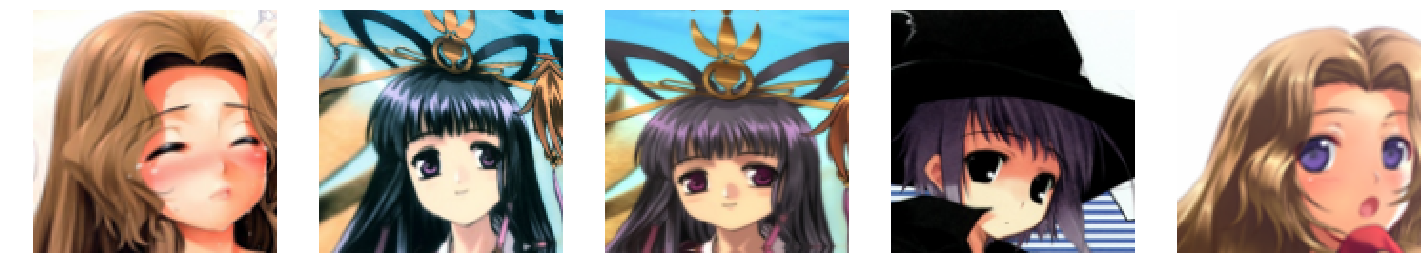

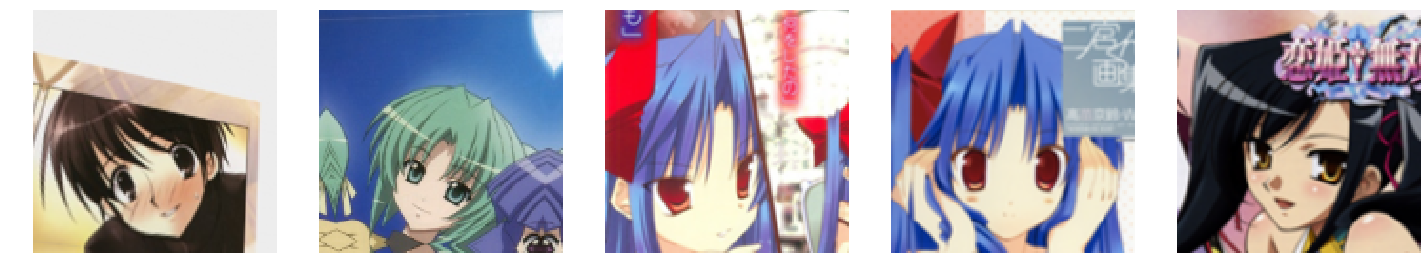

In [77]:
f = 50
print(f'Anime faces with the most/least of features {f}')
show_valid(sorts[f][0:5])
show_valid(sorts[f][-6:-1])

Anime faces with the most/least of features 10


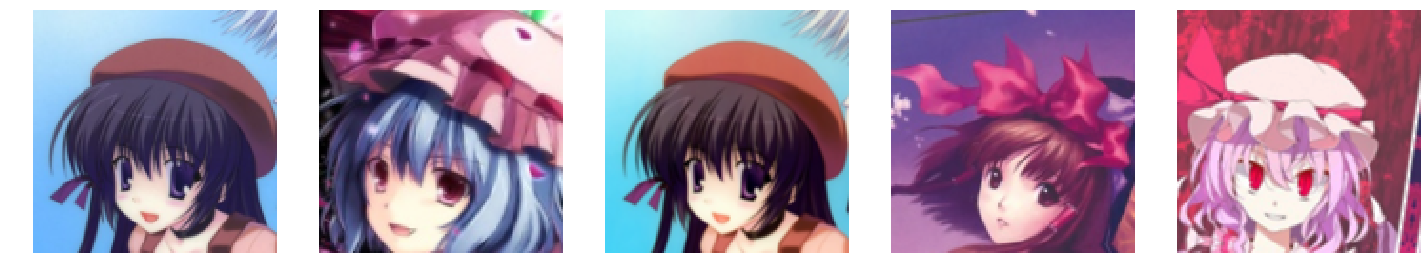

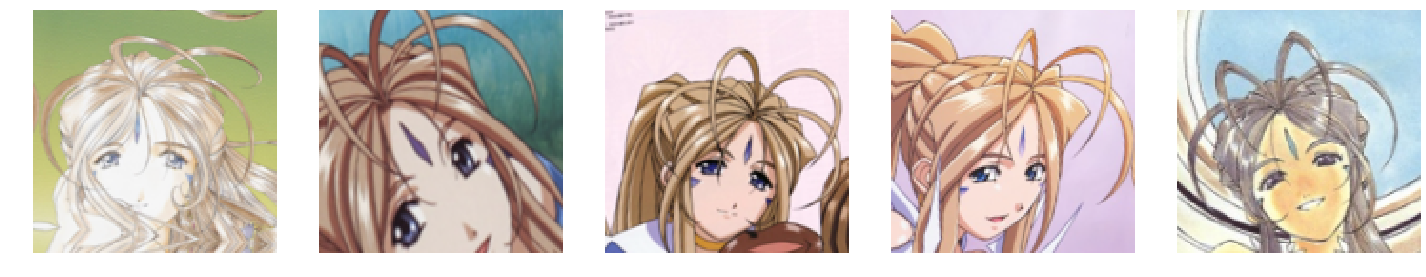

In [263]:
f = 10
print(f'Anime faces with the most/least of features {f}')
show_valid(sorts2[f][0:5])
show_valid(sorts2[f][-6:-1])

In [79]:
#LSH TIME! 

In [85]:
feature_dict = dict(zip(images, sf.features))
feature_dict2 = dict(zip(images, sf2.features))

In [86]:
pickle.dump(feature_dict, open(path/'feature_dict.p', 'wb'))
pickle.dump(feature_dict2, open(path/'feature_dict2.p', 'wb'))

In [87]:
feature_dict = pickle.load( open(path/'feature_dict.p', 'rb'))
feature_dict2 = pickle.load( open(path/'feature_dict2.p', 'rb'))

In [92]:
from lshash.lshash import LSHash
#local sensitivity hashing
k = 10 # hash size
L = 5 # number of tables
d = 512 # dimesnsion of the feature vector

lsh = LSHash(hash_size=k, num_hashtables=L, input_dim=d)
lsh2 = LSHash(hash_size=k, num_hashtables=L, input_dim=d)

In [93]:
for img_path, vec in(feature_dict.items()):
    lsh.index(vec.flatten(), img_path)
    
for img_path, vec in(feature_dict2.items()):
    lsh2.index(vec.flatten(), img_path)

In [94]:
pickle.dump(lsh, open(path/'lsh.p', 'wb'))
pickle.dump(lsh2, open(path/'lsh2.p', 'wb'))

In [97]:
lsh = pickle.load(open(path/'lsh.p', 'rb'))
lsh2 = pickle.load(open(path/'lsh2.p', 'rb'))

In [166]:
#time to visualise!
from PIL import Image

In [256]:
def get_similar_item(idx, feature_dict, lsh_variable, n_items = 5):
    response = lsh_variable.query(feature_dict[list(feature_dict.keys())[idx]].flatten(), 
                                        num_results = len(feature_dict)-1, distance_func = 'hamming') 
    columns = 5
    rows = int(np.ceil((n_items+1)*2/columns))
    fig=plt.figure(figsize=(20, 10))
    for i in range(1, 11):
        if i<n_items+1:
            img = Image.open(response[i-1][0][1])
            fig.add_subplot(rows, columns, i)
            plt.imshow(img)
        elif i > n_items:
            img = Image.open(response[(i-11)][0][1])
            fig.add_subplot(rows, columns, i)
            plt.imshow(img)

    return plt.tight_layout()


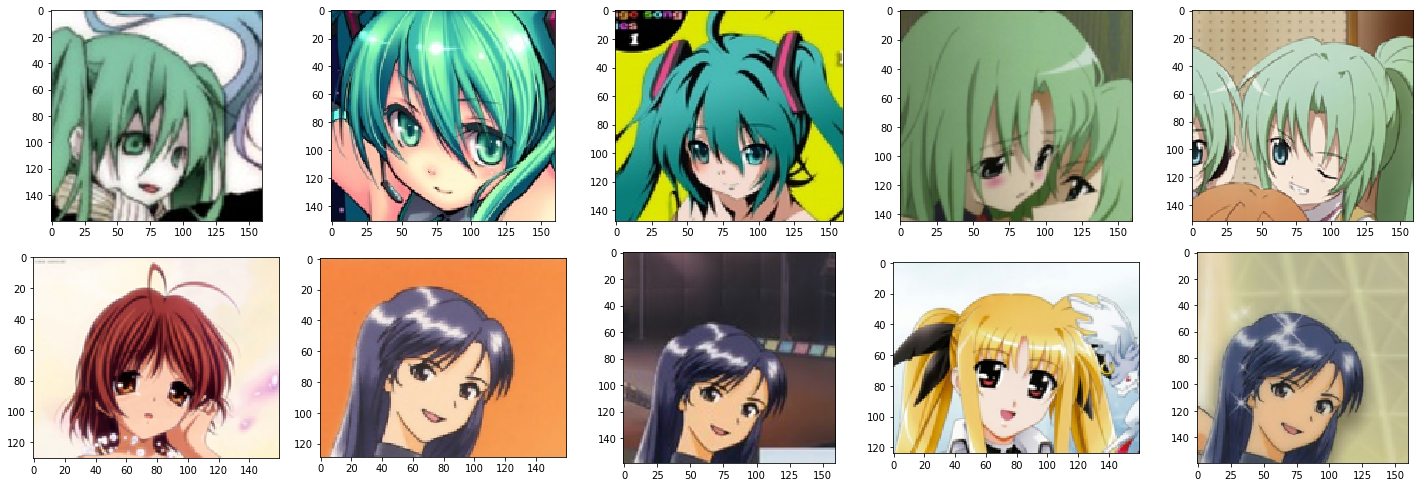

In [257]:
get_similar_item(0,feature_dict2,lsh2)

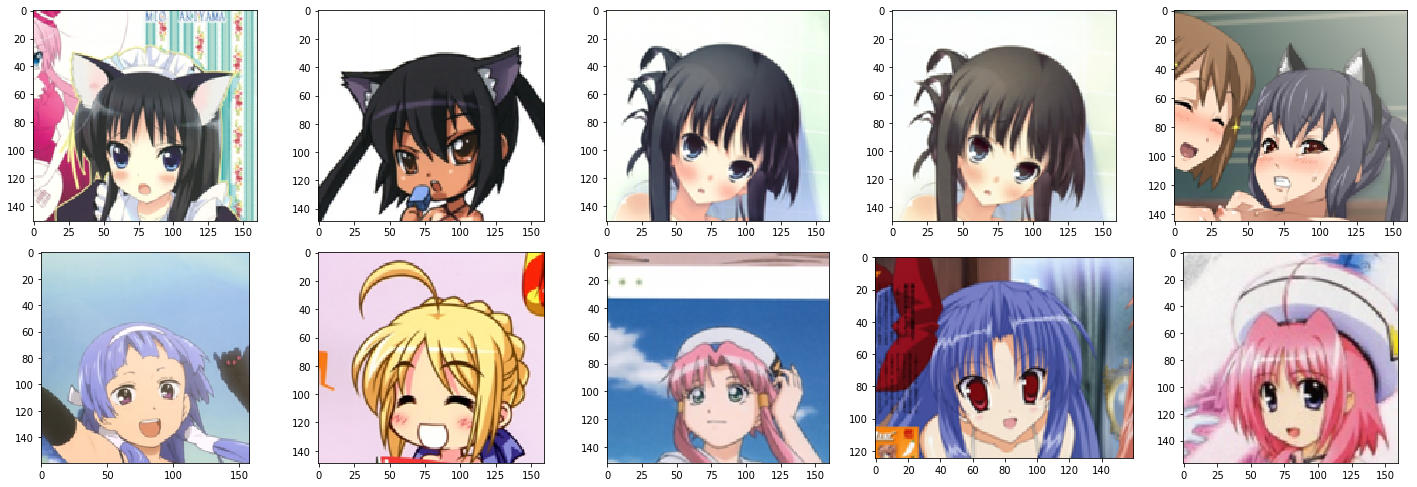

In [264]:
get_similar_item(511,feature_dict2,lsh2)

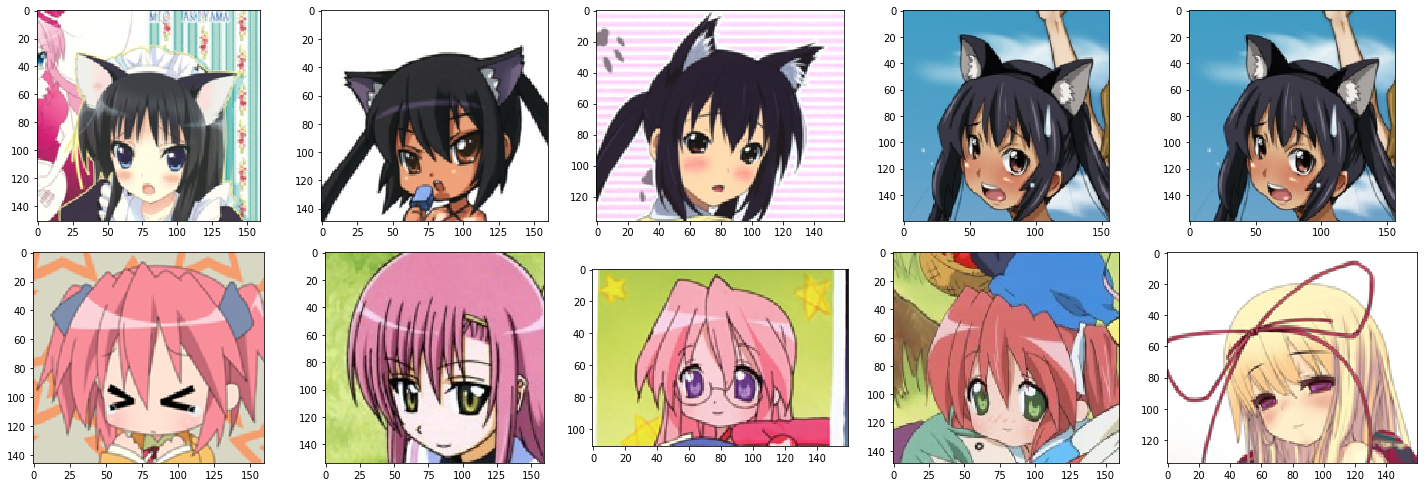

In [265]:
get_similar_item(511,feature_dict,lsh)

Anime faces with the most/least of features 511


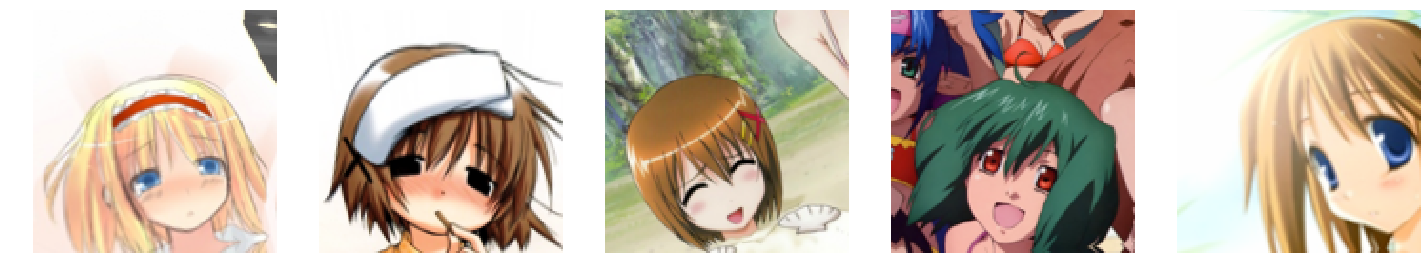

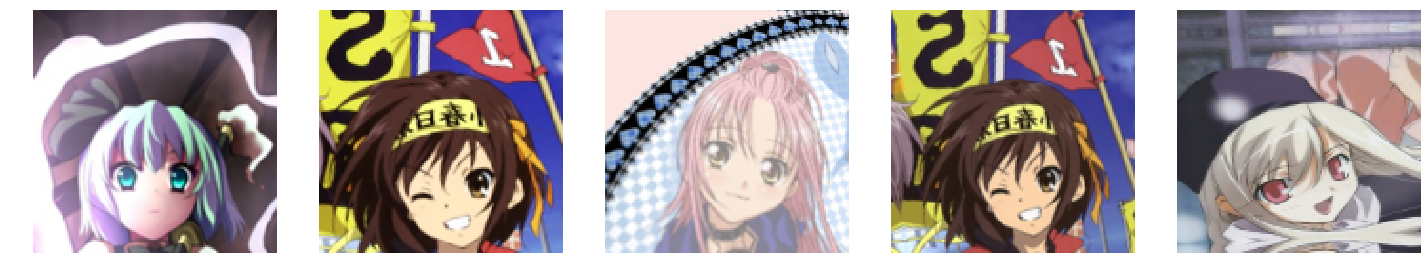

In [266]:
f = 511
print(f'Anime faces with the most/least of features {f}')
show_valid(sorts2[f][0:5])
show_valid(sorts2[f][-6:-1])

Anime faces with the most/least of features 511


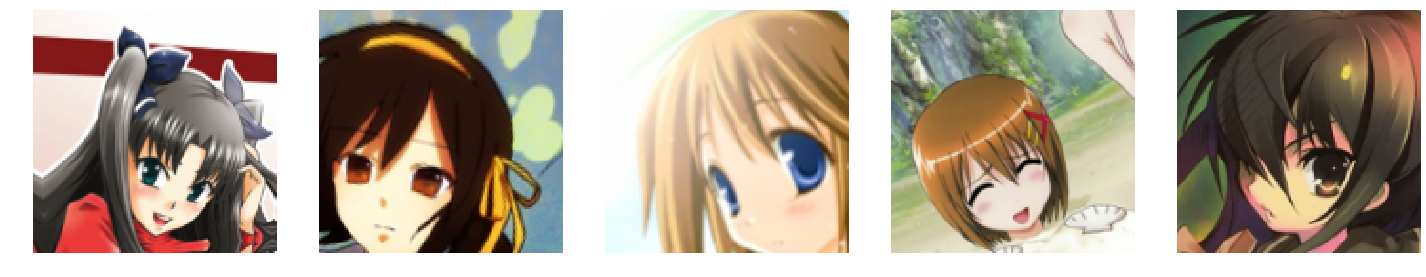

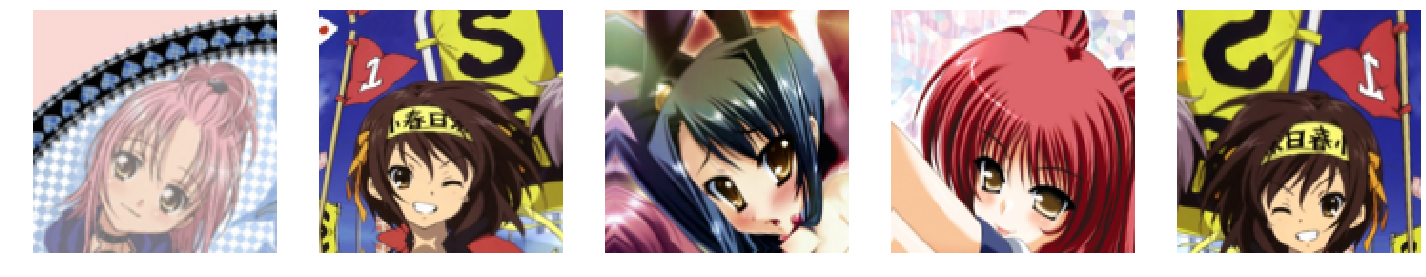

In [267]:
f = 511
print(f'Anime faces with the most/least of features {f}')
show_valid(sorts[f][0:5])
show_valid(sorts[f][-6:-1])